# Introduction

This notebook presents each of the example problems in the official [FEniCS tutorial](https://fenicsproject.org/pub/tutorial/html/ftut1.html), but in their super friendly pyironized format. For a description of the underlying physics/mathematics, please see the official documentation. The purpose here is as a rosetta stone to demonstrate the translation into pyiron.

At the moment it's also really a testbed so that I (Liam huber@mpie.de) can play around with our interface class(es) to see what is necessary and helpful across a broad selection of problems. These are also codified as integration tests to ensure nothing gets broken during development.

In [1]:
from pyiron import Project
import pyiron_contrib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pr = Project('fenics_tutorial')
pr.remove_jobs_silently(recursive=True)

# Fundamentals: Solving the Poisson equation

In [3]:
job = pr.create.job.Fenics('poisson', delete_existing_job=True)
job.domain = job.create.domain.unit_mesh.square(8, 8)

u_D = job.Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)  # String expressions must have valid C++ syntax
job.BC = job.create.bc.dirichlet(u_D)

job.LHS = job.dot(job.grad_u, job.grad_v) * job.dx
job.RHS = job.Constant(-6.0) * job.v * job.dx

In [4]:
job.run()

The job poisson was saved and received the ID: 169


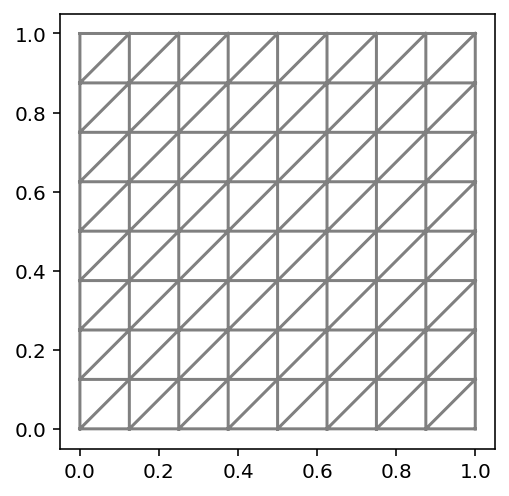

In [5]:
job.plot_mesh()

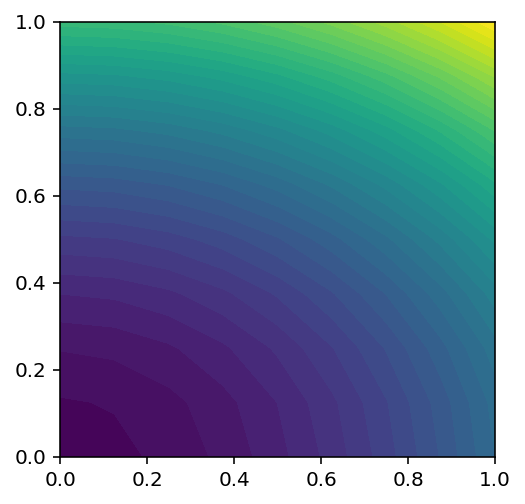

In [6]:
job.plot_solution()

In [7]:
error_L2 = job.fenics.errornorm(u_D, job.u, 'L2')

vertex_values_u_D = u_D.compute_vertex_values(job.mesh)
vertex_values_u = job.u.compute_vertex_values(job.mesh)

print('error_L2  =', error_L2)
print('error_max =', np.max(np.abs(vertex_values_u_D - vertex_values_u)))
      
# Try increasing the element order to 3 and the mesh resolution to see the error drop

error_L2  = 0.008235098073354827
error_max = 1.3322676295501878e-15


# Deflection of a membrane

In [8]:
job = pr.create.job.Fenics('membrane', delete_existing_job=True)
job.input.mesh_resolution = 64
job.input.element_order = 2

job.domain = job.create.domain.circle((0, 0), 1)
job.BC = job.create.bc.dirichlet(job.Constant(0))

p = job.Expression('4*exp(-pow(beta, 2)*(pow(x[0], 2) + pow(x[1] - R0, 2)))', degree=1, beta=8, R0=0.6)
job.LHS = job.dot(job.grad_u, job.grad_v) * job.dx
job.RHS = p * job.v * job.dx

In [9]:
job.run()

The job membrane was saved and received the ID: 170


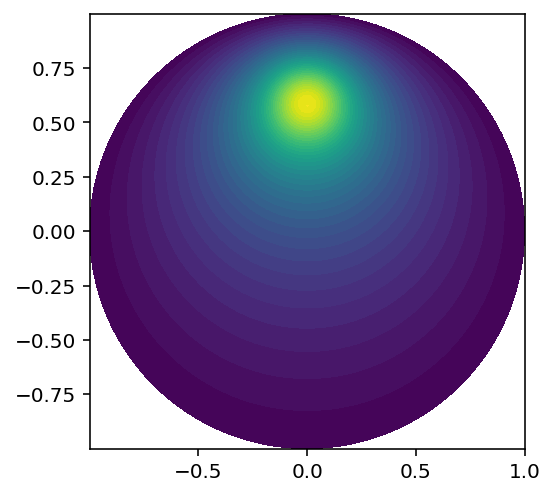

In [10]:
job.plot_solution()

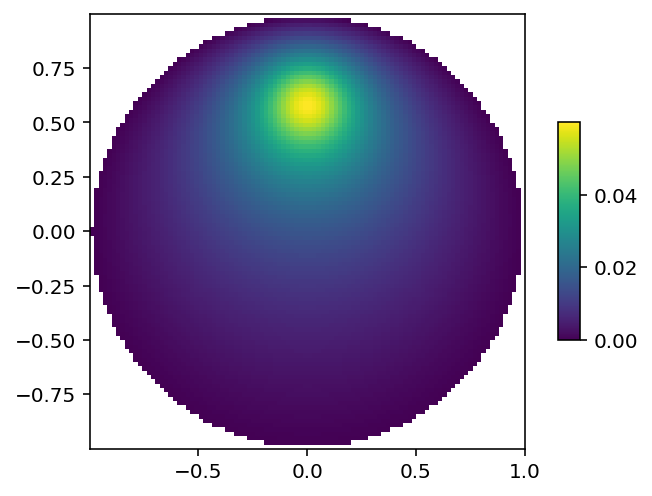

In [11]:
job.plot_output(n_grid=100);  # Our simple output plotter also works for non-square mesh-shapes
# Here we drop the interpolation parameter to see the coarse-grained-ness

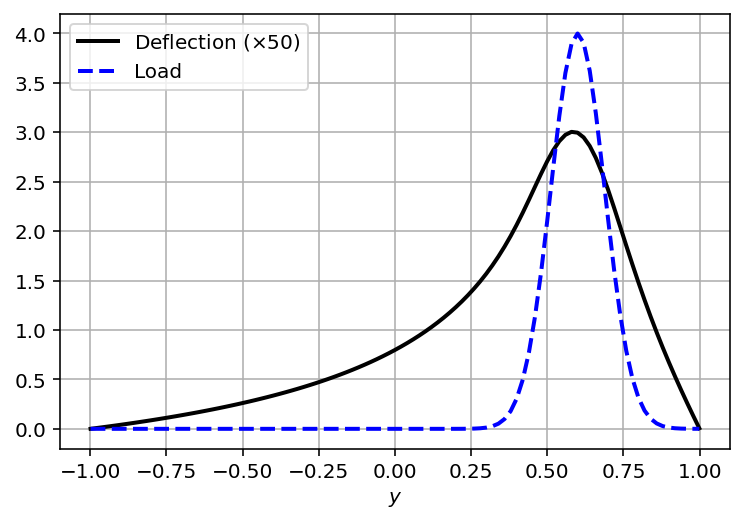

In [12]:
tol = 0.001  # avoid hitting points outside the domain
y = np.linspace(-1 + tol, 1 - tol, 101)
points = [(0, y_) for y_ in y]  # 2D points cutting a vertical line through the center of the domain
w_line = np.array([job.u(point) for point in points])
p_line = np.array([p(point) for point in points])

plt.plot(y, 50*w_line, 'k', linewidth=2)  # magnify w
plt.plot(y, p_line, 'b--', linewidth=2)
plt.grid(True)
plt.xlabel('$y$')
plt.legend(['Deflection ($\\times 50$)', 'Load'], loc='upper left');

# The heat equation

In [13]:
job = pr.create.job.Fenics('heat', delete_existing_job=True)
job.input.n_steps = 10
job.input.dt = 2.0 / job.input.n_steps

job.domain = job.create.domain.unit_mesh.square(8, 8)

u_D = job.Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t', degree=2, alpha=3, beta=1.2, t=0)
job.BC = job.create.bc.dirichlet(u_D)

u_n = job.interpolate_function(u_D)  # TODO: Make job method with automatic V

f = job.Constant(u_D.beta - 2 - 2*u_D.alpha)
job.F = job.u * job.v * job.dx + job.input.dt * job.dot(job.grad_u, job.grad_v) * job.dx \
        - (u_n + job.input.dt * f) * job.v * job.dx

job.time_dependent_expressions.append(u_D)
job.assigned_u = u_n

# TODO?: Add error calculation to the run loop? Interpolation at each step seems costly...

In [14]:
job.run()

The job heat was saved and received the ID: 171


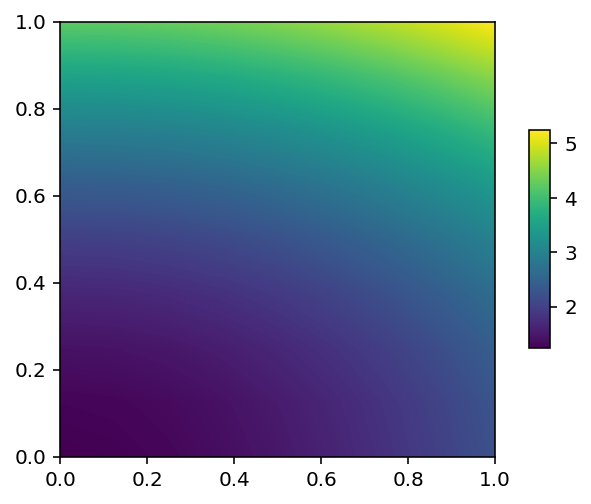

In [15]:
job.plot_output(frame=0);

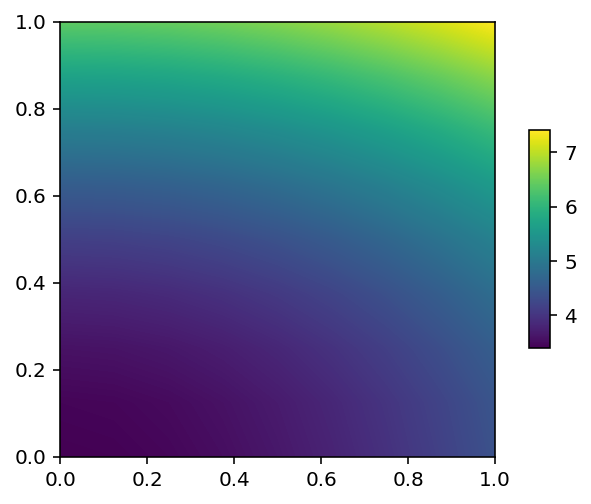

In [16]:
job.plot_output(frame=-1);

# Diffusion of a Gaussian function

In [17]:
job = pr.create.job.Fenics('gauss', delete_existing_job=True)
job.input.n_steps = 50
job.input.dt = 2.0 / job.input.n_steps

job.domain = job.create.domain.regular_mesh.rectangle((-2, -2), (2, 2), 30, 30)
job.BC = job.create.bc.dirichlet(job.Constant(0))

u_0 = job.Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', degree=2, a=5)
u_n = job.interpolate_function(u_0)

f = job.Constant(0)
job.F = job.u * job.v * job.dx + job.input.dt * job.dot(job.grad_u, job.grad_v) * job.dx \
        - (u_n + job.input.dt * f) * job.v * job.dx

job.assigned_u = u_n

In [18]:
job.run()

The job gauss was saved and received the ID: 172


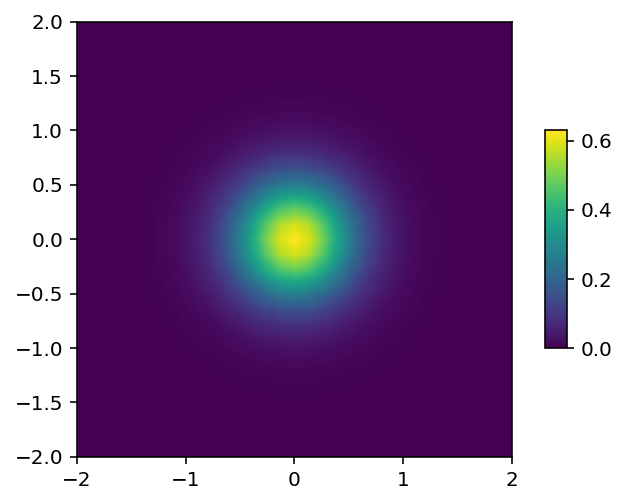

In [19]:
job.plot_output(frame=0);

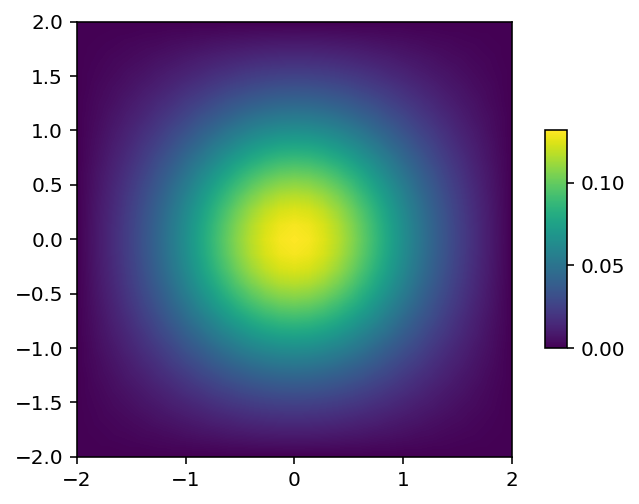

In [20]:
job.plot_output(frame=8);

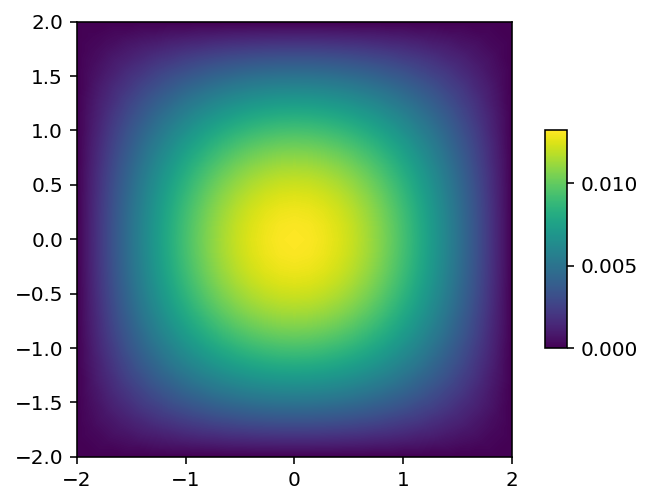

In [21]:
job.plot_output(frame=-1);

# Nonlinear Poisson

In [22]:
job = pr.create.job.Fenics('poisson_nonlinear', delete_existing_job=True)

def q(u):
    """Return nonlinear coefficient"""
    return 1 + u**2

x, y = job.sympy.symbols('x[0], x[1]')
u = 1 + x + 2*y
f = - job.sympy.diff(q(u) * job.sympy.diff(u, x), x) - job.sympy.diff(q(u) * job.sympy.diff(u, y), y)
f = job.sympy.simplify(f)
u_code = job.sympy.printing.ccode(u)
f_code = job.sympy.printing.ccode(f)

job.domain = job.create.domain.unit_mesh.square(8, 8)

u_D = job.Expression(u_code, degree=1)
job.BC = job.create.bc.dirichlet(u_D)

f = job.Expression(f_code, degree=1)
job.LHS = q(job.solution) * job.dot(job.grad_solution, job.grad_v) * job.dx - f * job.v * job.dx
job.RHS = 0

In [23]:
print('u =', u_code)
print('f =', f_code)

u = x[0] + 2*x[1] + 1
f = -10*x[0] - 20*x[1] - 10


In [24]:
job.run()

The job poisson_nonlinear was saved and received the ID: 173


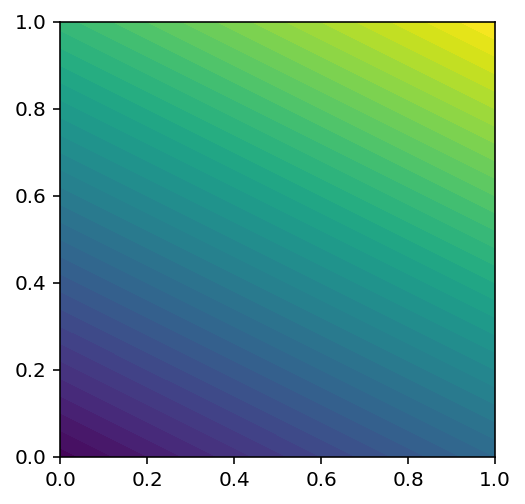

In [25]:
job.plot_solution()

# Linear Elasticity

In [26]:
# Scaled variables
L = 1; W = 0.2
mu = 1
rho = 1
delta = W/L
gamma = 0.4 * delta**2
beta = 1.25
lambda_ = beta
g = gamma

job = pr.create.job.Fenics('linear_elasticity', delete_existing_job=True)
job.V_class = job.fenics.VectorFunctionSpace
job.domain = job.create.domain.regular_mesh.box((0, 0, 0), (L, W, W), 10, 3, 3)

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < 1e-14

job.BC = job.create.bc.dirichlet(job.Constant((0, 0, 0)), bc_fnc=clamped_boundary)

# Define strain and stress
# TODO: These helpers could be in a special elasticity Fenics job subclass
def epsilon(u):
    return 0.5 * (job.nabla_grad(u) + job.nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_ * job.nabla_div(u) * job.Identity(u.geometric_dimension()) + 2 * mu * epsilon(u)

f = job.Constant((0, 0, -rho * g))
T = job.Constant((0, 0, 0))
job.LHS = job.inner(sigma(job.u), epsilon(job.v)) * job.dx
job.RHS = job.dot(f, job.v) * job.dx + job.dot(T, job.v) * job.ds

In [27]:
job.run()

The job linear_elasticity was saved and received the ID: 174


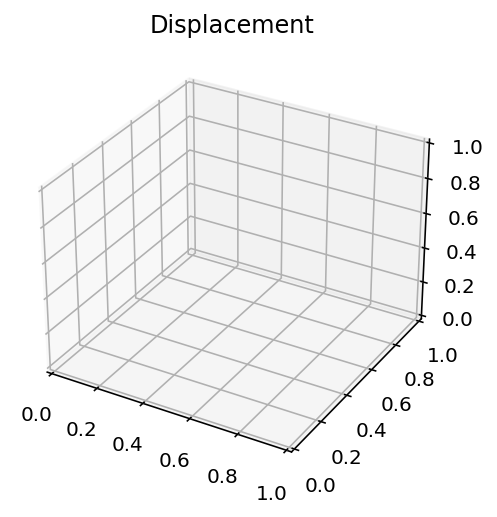

In [28]:
job.plot(job.solution, title='Displacement', mode='displacement')
# Uh-oh! Nothing plots!
# I'm not sure if this is a problem on my end or theirs -- 
# fenics plot for 3D spaces was broken to begin with, 
# and the tutorials are for an outdated version of the code (e.g., 
# I had to import nabla_div from ufl since it's not in fenics now).

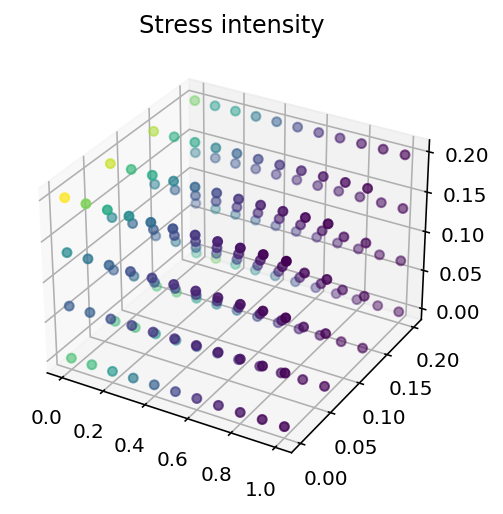

In [29]:
s = sigma(job.solution) - (1./3) * job.tr(sigma(job.solution)) * job.Identity(job.solution.geometric_dimension())  # deviatoric stress
von_Mises = job.fenics.project(job.sqrt(3./2 * job.inner(s, s)), job.fenics.FunctionSpace(job.mesh, 'P', 1))
job.plot(von_Mises, title='Stress intensity');

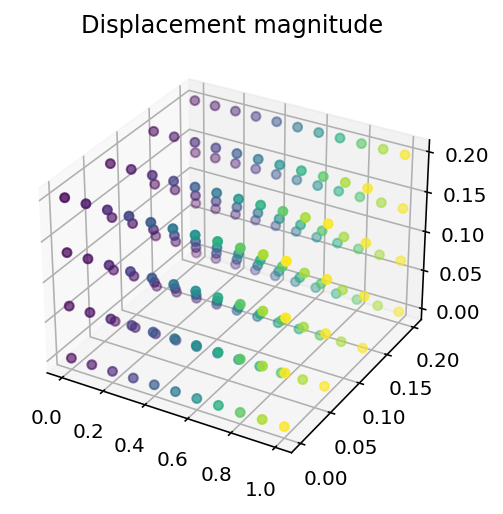

In [30]:
# Compute magnitude of displacement
u_magnitude = job.sqrt(job.dot(job.solution, job.solution))
u_magnitude = job.fenics.project(u_magnitude, job.fenics.FunctionSpace(job.mesh, 'P', 1))
job.plot(u_magnitude, title='Displacement magnitude');